In [2]:
!sudo apt install tesseract-ocr -y
!sudo apt install libtesseract-dev -y
!sudo apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.4).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [3]:
!pip install langchain pydantic lxml openai chromadb tiktoken opencv-python


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
! pip install "unstructured[all-docs]"


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [5]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [6]:
import os

os.environ['OPENAI_API_KEY'] = "<OPENAI_API_KEY>"

In [7]:
!cd youtube-tutorial

In [8]:
raw_pdf_elements = partition_pdf(
    filename="/teamspace/studios/this_studio/youtube-tutorial/AlcuzcuzHotel.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir="figure",
)

In [9]:
from dotenv import load_dotenv

load_dotenv()

openai_api_key = os.environ["OPENAI_API_KEY"]

In [10]:
# Get text summaries and table summaries
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

/tmp/ipykernel_159024/2083346215.py:13: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm=ChatOpenAI(model="gpt-3.5-turbo", openai_api_key = openai_api_key, max_tokens=1024),


/tmp/ipykernel_159024/2083346215.py:12: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  summary_chain = LLMChain(
/tmp/ipykernel_159024/2083346215.py:20: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summary_chain.run({'element_type': 'text', 'element': e})


In [11]:
text_elements

['Alcuzcuz Hotel\n\nYour hotel in Malaga\n\nWelcome to our little paradise\n\nAlcuzcuz Hotel Boutique , an “Adults only” hotel, is hidden away among the dry greenery of the Ronda mountain range , in the village of Benahavis , one of the most emblematic and exclusive houses on the Costa del Sol . A Malaga farmhouse built in 1850, plastered in ochre colour and with a romantic garden that extends around it, full of aromas and colour and that seems to grow by itself, helped by the bonanza of a warm and pleasant climate.\n\nA unique space in Benahavis\n\nAlcuzcuz enjoys absolute privacy , providing a serene and peaceful atmosphere that invites you to disconnect from the rest of the world, an idyllic place to spend some unforgettable days of rest.\n\nFor the last 30 years it has been the residence of the famous interior designer Jaime Parladé , preserving its artistic touch, with antique furniture, works of art and a great history inside, as it has belonged to the same family for six generat

In [12]:
output_path="figures"

In [13]:
# Get image summaries
image_elements = []
image_summaries = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

def summarize_image(encoded_image):
    prompt = [
        SystemMessage(content="You are a bot that is good at analyzing images related to Dog's health."),
        HumanMessage(content=[
            {
                "type": "text",
                "text": "Describe the contents of this image."
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = ChatOpenAI(model="gpt-4-vision-preview", openai_api_key=openai_api_key, max_tokens=1024).invoke(prompt)
    return response.content

for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        summary = summarize_image(encoded_image)
        image_summaries.append(summary)

In [14]:
image_elements[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHxAnIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1SiikxXCd43vQaXGKQ0hkckYdSGAI96aFwcdKlOOmKZxmkUNNJTiOaMCkNDCMU2nsaTvQURmjtTsUY4qGhkRHFMIqUim44pDRERSD6VIRTCOaRaIyvJ4qFqskZFQsOaloZHionWpyKjYZNSykRKzRnKnmrKXKPw+Fb36VAwF

In [15]:
image_summaries[1]

"The image is a collage of four different photos, mainly depicting interior spaces that seem to be part of a house or accommodation facility.\n\nThe top large photo shows a bedroom with two single beds covered in red bedspreads and white pillows. There's a variety of framed artwork on the wall above the beds, and the room has traditional or antique-style furniture, including a desk, a chest of drawers, and a standing mirror. The floor is covered with a textured rug, and there's an intricately designed rug hanging on the wall, which adds a cultural or vintage feel to the room. A lamp on each bedside table provides lighting.\n\nIn the bottom left photo, there's an exterior view that features a quaint courtyard or patio area with plants, outdoor furniture, and a tiled pathway leading to a door. The setting appears serene and inviting, with a sense of privacy and tranquility.\n\nThe bottom center photo shows an indoor space with a checkerboard floor, a wooden table with chairs, and open do

In [16]:
!pip install faiss-cpu


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [17]:
# Create Documents and Vectorstore
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

# for e, s in zip(table_elements, table_summaries):
#     doc = Document(
#         page_content = s,
#         metadata = {
#             'id': i,
#             'type': 'table',
#             'original_content': e
#         }
#     )
#     retrieve_contents.append((i, e))
#     documents.append(doc)

for e, s in zip(image_elements, image_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))

/tmp/ipykernel_159024/131063319.py:42: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = FAISS.from_documents(documents=documents, embedding=OpenAIEmbeddings(openai_api_key=openai_api_key))


In [ ]:
vectorstore.save_local("faiss_index3")

In [ ]:

embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)

In [1]:
ls

app.py*           faiss_index1/    getting_started.ipynb*  rag_model_youtube/
chroma_db3/       faiss_index2/    new-folder1/            sample/
cloud-demo/       figures/         newapp.py*              webrtc/
cloud_ui/         final-soultion/  nltk_data/              youtube-tutorial/
dataset.py*       finetune.py*     output1/
development.env*  flask_session/   rag_model_office/


In [ ]:
new_db1 = FAISS.load_local("faiss_index3", embeddings,allow_dangerous_deserialization=True)


In [ ]:
prompt_template = """

Answer the question based only on the following context, which can include text, images:
{context}
Question: {question}
Just return the helpful answer in as much as detailed possible. Provide best image based on context and description of image.
Answer:
"""

In [ ]:
qa_chain = LLMChain(llm=ChatOpenAI(model="gpt-4o-mini", openai_api_key = openai_api_key, max_tokens=1024),
                        prompt=PromptTemplate.from_template(prompt_template))

In [ ]:
def answer(question):
    relevant_docs = new_db1.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [ ]:
result, relevant_images = answer("tell me about Patio")
print(result)

The text does not provide specific details about "The Patio".


In [ ]:
relevant_images[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHxAnIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1SiikxXCd43vQaXGKQ0hkckYdSGAI96aFwcdKlOOmKZxmkUNNJTiOaMCkNDCMU2nsaTvQURmjtTsUY4qGhkRHFMIqUim44pDRERSD6VIRTCOaRaIyvJ4qFqskZFQsOaloZHionWpyKjYZNSykRKzRnKnmrKXKPw+Fb36VAwF

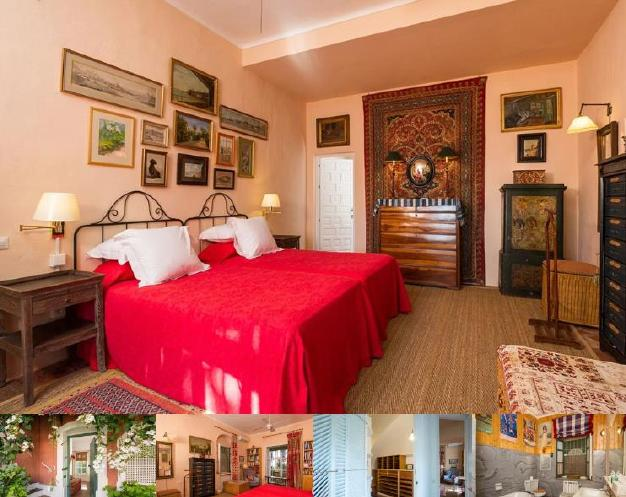

In [ ]:
display.display(display.Image(base64.b64decode(relevant_images[0])))